In [22]:
import os, shutil
import pathlib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
from tensorflow import keras


In [23]:
physical_devices = tf.config.list_physical_devices('GPU')

In [24]:
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [25]:
base_dir = '/home/kailash/VScode Python projects/tf/conv/dataset_cat_dog/'

In [26]:
train_dir = os.path.join(base_dir,'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')

In [27]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [28]:
AUTOTUNE = tf.data.AUTOTUNE

In [29]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,batch_size=40)

Found 6000 files belonging to 2 classes.


In [30]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [31]:
val_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,batch_size=40)

Found 2000 files belonging to 2 classes.


In [32]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,batch_size=40)

Found 2000 files belonging to 2 classes.


In [33]:
train_ds.class_names

['cats', 'dogs']

In [34]:
# image, label = next(iter(train_ds))


# _ = plt.imshow(np.array(image,np.int32))


In [35]:
IMG_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
   keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
   keras.layers.Rescaling(1./255)
   
])

In [36]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(40),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomTranslation(.2,.2),
  tf.keras.layers.RandomZoom(.2),
  tf.keras.layers.RandomHeight(.2),
  tf.keras.layers.RandomWidth(.2)
])

In [37]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [38]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(40, 256, 256, 3)
(40,)


In [39]:
train_ds


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [55]:
def optimise_aug(ds,shuffle=False,augment=False):
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)


    
    if augment:
        ds = ds.map(lambda x,y : (data_augmentation(x),y),num_parallel_calls=AUTOTUNE)
    
    return ds.cache().prefetch(buffer_size=AUTOTUNE)


In [56]:
train_ds = optimise_aug(train_ds,shuffle=True,augment=True)
val_ds = optimise_aug(val_ds)



In [57]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [58]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [59]:
test_ds
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [60]:
active = tf.keras.activations.relu
initial = tf.keras.initializers.he_uniform

In [61]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Conv2D(32,(3,3),padding = "same",activation="relu",input_shape=(150,150,3)))
# model.add(tf.keras.layers.MaxPooling2D((2,2)))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Conv2D(64, (3, 3),padding = "same", activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D((2, 2)))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same",activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D((2, 2)))
# model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same",activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [62]:
model = tf.keras.models.Sequential()


model.add(tf.keras.layers.Conv2D(32,(3,3),padding = "same",activation=active,input_shape=(150,150,3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Dropout(0.2))


model.add(tf.keras.layers.Conv2D(64, (3, 3),padding = "same", activation=active))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same",activation=active))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same",activation=active))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation=active))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64,activation=active))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32,activation=active))

model.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid))


In [63]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 37, 37, 64)       

In [64]:

model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),metrics='acc')

In [65]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cats_dog_classifier",save_best_only=True)

In [66]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [67]:
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run%d-%H_%M")+"mapdataset"
    return os.path.join(root_logdir, run_id)


run_logdir = get_run_logdir()


In [68]:

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,profile_batch='5,10',write_images=True) 

In [69]:
history = model.fit(train_ds,epochs=50,validation_data=val_ds,callbacks=[tensorboard_cb])

Epoch 1/50
 29/150 [====>.........................] - ETA: 9s - loss: 0.6932 - acc: 0.4853

KeyboardInterrupt: 

: 

In [ ]:
test_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
model.evaluate(test_ds)

50/50 [==============================] - 1s 26ms/step - loss: 0.5696 - acc: 0.7965


[0.5696187019348145, 0.796500027179718]

In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

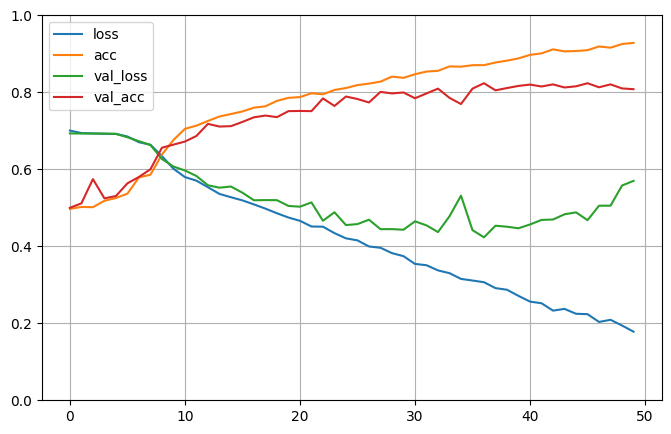

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
!tensorboard  --logdir=./my_logs --port=6006

/bin/bash: /home/kailash/anaconda3/envs/tensorflow1/lib/libtinfo.so.6: no version information available (required by /bin/bash)

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.10.0 at http://localhost:6006/ (Press CTRL+C to quit)
